## 1. Mesh generation with Gmsh Python API

<img src="Northridge_mesh" width="50%">

+ http://gmsh.info/
+ https://gitlab.onelab.info/gmsh/gmsh.git


In [ ]:
#load modulus
#pip install gmsh  #if needed
#pip install pyproj #if needed
import gmsh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pyproj import Proj,transform
#import sys

#load topography data from 
def read_elevation_from_file(hgt_file, lon, lat, SAMPLES):
    with open(hgt_file, 'rb') as hgt_data:
        # Each data is 16bit signed integer(i2) - big endian(>)
        elevations = np.fromfile(hgt_data, np.dtype('>i2'), SAMPLES*SAMPLES).reshape((SAMPLES, SAMPLES))
        
        return np.flipud(elevations)

### Downloading topography 

In [2]:
# Lower left corner of the selected area 
lat, lon = 34, -119
min_latitude= lat 
min_longitude=lon

# Download it from NASA earthdata https://search.earthdata.nasa.gov/search
# dataset: NASA Shuttle Radar Topography Mission Global 3 arc second V003

filename = 'N%dW%03d.hgt'%(int(min_latitude),int(abs(min_longitude)))

### Reading topography data

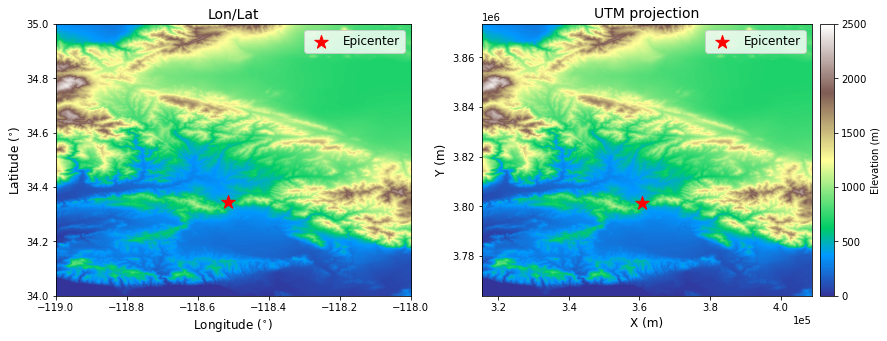

In [3]:
# Samples of the original topographic data in each direction
samples = 1201    
topo = read_elevation_from_file(filename,int(min_latitude),int(min_longitude),samples)

# These data contain occassional voids from a number of causes such as shadowing, 
# phase unwrapping anomalies, or other radar-specific causes. Voids are flagged with the value -32768.
# I replace them by the average of the surrounding values
mark_x = np.where( topo == -32768 )[0]
mark_y = np.where( topo == -32768 )[1]
for x, y in zip(mark_x, mark_y) :
    slice = topo[max(0, x-1):x+1, max(0,y-1):y+1] # assuming a 5x5 square
    topo[x,y] = np.mean([i for i in slice.flatten() if i > 0])  # threshold is 0

x_lon = np.linspace(int(min_longitude),int(min_longitude)+1,samples)
y_lat = np.linspace(int(min_latitude),int(min_latitude)+1,samples)

# UTM projection
lla = Proj(proj='latlong', ellps='WGS84', datum='WGS84')
myproj = Proj(proj='utm',zone='11U',ellps='WGS84', datum='WGS84')
xyz_map = transform(lla, myproj, x_lon,y_lat,np.zeros(len(x_lon)), radians=False)
x = xyz_map[0]
y = xyz_map[1]

# Epicenter of 1994 Northridge earthquake: geographic coordinates
lat_sou = 34.3440
lon_sou = -118.5150 
xyz_sou = transform(lla, myproj,lon_sou,lat_sou, radians=False) # Epicenter in UTM domain


# Plot topography
fig, ax = plt.subplots(1,2,figsize=(14,5))

# Lat/Lon 
im1 = ax[0].imshow(topo, interpolation='bilinear', cmap='terrain',aspect='auto',
                   origin='lower', extent=[x_lon[0], x_lon[-1], y_lat[0], y_lat[-1]],
                   vmax=2500, vmin=0)
ax[0].set_title('Lon/Lat',fontsize=14)
ax[0].set_xlabel('Longitude ($^{\circ}$)', fontsize=12)
ax[0].set_ylabel('Latitude ($^{\circ}$)', fontsize=12)
ax[0].scatter(lon_sou,lat_sou, s=200, marker='*', c='r',label='Epicenter')
ax[0].legend(loc=1,prop={"size":12})

# UTM domain
im2 = ax[1].imshow(topo, interpolation='bilinear', cmap='terrain',aspect='auto',
                   origin='lower', extent=[x[0], x[-1], y[0], y[-1]],
                    vmax=2500, vmin=0)
ax[1].scatter(xyz_sou[0],xyz_sou[1], s=200, marker='*', c='r',label='Epicenter')
ax[1].xaxis.major.formatter.set_powerlimits((-2,1))
ax[1].yaxis.major.formatter.set_powerlimits((-2,1))
ax[1].set_xlabel('X (m)', fontsize=12)
ax[1].set_ylabel('Y (m)', fontsize=12)
ax[1].set_title('UTM projection',fontsize=14)
ax[1].legend(loc=1,prop={"size":12})
fig.colorbar(im2,ax=ax[1],label='Elevation (m)', fraction=0.046, pad=0.025)

plt.show()

### Mesh generation

In [4]:
# setup Model geometry dimension: 70 km by 70 km by 35 km

xmin = xyz_sou[0]-35000. # Unit (m)
xmax = xyz_sou[0]+35000. 

ymin = xyz_sou[1]-35000.
ymax = xyz_sou[1]+35000.

zmax = -35000.


In [8]:
# start to mesh using GMSH; Please specify element size lc and lc_surf as desinged.

# Initialize Gmsh API
gmsh.initialize()
gmsh.model.add("Northridge")

## set Element size in meter
lc = 2e3 
lc_surf = 0.5e3

# Resample original topographic data: 1201 by 1201 to 101 by 101
# Create the terrain mesh with N by N data points:
N = 100

# Helper function to return a node tag given two indices i and j:
def tag(i, j):
    return (N + 1) * i + j + 1

# The x, y, z coordinates of all the nodes:
coords = []

# The tags of the corresponding nodes:
nodes = []

# The connectivities of the triangle elements (3 node tags per triangle) on the
# terrain surface:
tris = []

# The connectivities of the line elements on the 4 boundaries (2 node tags
# for each line element):
lin = [[], [], [], []]

# The connectivities of the point elements on the 4 corners (1 node tag for each
# point element):
pnt = [tag(0, 0), tag(N, 0), tag(N, N), tag(0, N)]

# Adding topography point by point
x_grid = np.linspace(xmin,xmax,N+1)
y_grid = np.linspace(ymin,ymax,N+1)

for i in range(N + 1):
    for j in range(N + 1):
        nodes.append(tag(i, j))
        ind_x = (np.abs(x_grid[i]-x)).argmin() # find the X index of nearest point in topo matrix
        ind_y = (np.abs(y_grid[j]-y)).argmin() # find the Y index of nearest point in topo matrix
        coords.extend([x_grid[i],y_grid[j],np.float(topo[ind_y,ind_x])]) # Add the elevation 
        if i > 0 and j > 0:
            tris.extend([tag(i - 1, j - 1), tag(i, j - 1), tag(i - 1, j)]) 
            tris.extend([tag(i, j - 1), tag(i, j), tag(i - 1, j)])
        if (i == 0 or i == N) and j > 0:
            lin[3 if i == 0 else 1].extend([tag(i, j - 1), tag(i, j)])
        if (j == 0 or j == N) and i > 0:
            lin[0 if j == 0 else 2].extend([tag(i - 1, j), tag(i, j)])

# Create 4 discrete points for the 4 corners of the terrain surface:
for i in range(4):
    gmsh.model.addDiscreteEntity(0, i + 1)
gmsh.model.setCoordinates(1, xmin, ymin, coords[3 * tag(0, 0) - 1])
gmsh.model.setCoordinates(2, xmax, ymin, coords[3 * tag(N, 0) - 1])
gmsh.model.setCoordinates(3, xmax, ymax, coords[3 * tag(N, N) - 1])
gmsh.model.setCoordinates(4, xmin, ymax, coords[3 * tag(0, N) - 1])

# Create 4 discrete bounding curves, with their boundary points:
for i in range(4):
    gmsh.model.addDiscreteEntity(1, i + 1, [i + 1, i + 2 if i < 3 else 1])

# Create one discrete surface, with its bounding curves:
gmsh.model.addDiscreteEntity(2, 1, [1, 2, -3, -4])

# Add all the nodes on the surface:
gmsh.model.mesh.addNodes(2, 1, nodes, coords)
gmsh.model.addPhysicalGroup(2, [1], 101) # Free-surface boundary label

# Add point elements on the 4 points, line elements on the 4 curves, and triangle elements on the surface:
for i in range(4):
    # Type 15 for point elements:
    gmsh.model.mesh.addElementsByType(i + 1, 15, [], [pnt[i]])
    # Type 1 for 2-node line elements:
    gmsh.model.mesh.addElementsByType(i + 1, 1, [], lin[i])
# Type 2 for 3-node triangle elements:
gmsh.model.mesh.addElementsByType(1, 2, [], tris)

# Reclassify the nodes on the curves and the points 
gmsh.model.mesh.reclassifyNodes()

# Create a geometry for the discrete curves and surfaces, so that we can remesh them later on:
gmsh.model.mesh.createGeometry()

# Create other entities to form one volume below the terrain surface:
p1 = gmsh.model.geo.addPoint(xmin, ymin, zmax)
p2 = gmsh.model.geo.addPoint(xmax, ymin, zmax)
p3 = gmsh.model.geo.addPoint(xmax, ymax, zmax)
p4 = gmsh.model.geo.addPoint(xmin, ymax, zmax)
c1 = gmsh.model.geo.addLine(p1, p2)
c2 = gmsh.model.geo.addLine(p2, p3)
c3 = gmsh.model.geo.addLine(p3, p4)
c4 = gmsh.model.geo.addLine(p4, p1)
c10 = gmsh.model.geo.addLine(p1, 1)
c11 = gmsh.model.geo.addLine(p2, 2)
c12 = gmsh.model.geo.addLine(p3, 3)
c13 = gmsh.model.geo.addLine(p4, 4)
ll1 = gmsh.model.geo.addCurveLoop([c1, c2, c3, c4]) 
s1 = gmsh.model.geo.addPlaneSurface([ll1]) # bot
ll3 = gmsh.model.geo.addCurveLoop([c1, c11, -1, -c10]) # fro
s3 = gmsh.model.geo.addPlaneSurface([ll3]) # fro
ll4 = gmsh.model.geo.addCurveLoop([c2, c12, -2, -c11])
s4 = gmsh.model.geo.addPlaneSurface([ll4]) # rig
ll5 = gmsh.model.geo.addCurveLoop([c3, c13, 3, -c12])
s5 = gmsh.model.geo.addPlaneSurface([ll5]) # bac 
ll6 = gmsh.model.geo.addCurveLoop([c4, c10, 4, -c13])
s6 = gmsh.model.geo.addPlaneSurface([ll6]) # lef
gmsh.model.addPhysicalGroup(2, [s1, s3, s4, s5, s6], 105)  # Absorbing boundary label
sl1 = gmsh.model.geo.addSurfaceLoop([s1, s3, s4, s5, s6, 1])
v1 = gmsh.model.geo.addVolume([sl1])
gmsh.model.addPhysicalGroup(3, [v1], 1)
gmsh.model.geo.synchronize()


# setup key mesh parameters
gmsh.model.mesh.field.add("Distance", 1)
gmsh.model.mesh.field.setNumbers(1, "EdgesList", [1,2,3,4])
gmsh.model.mesh.field.setNumbers(1, "FacesList", [1])

gmsh.model.mesh.field.add("Threshold", 2)
gmsh.model.mesh.field.setNumber(2, "IField", 1)
gmsh.model.mesh.field.setNumber(2, "LcMin", lc_surf)#/ 20
gmsh.model.mesh.field.setNumber(2, "LcMax", lc)
gmsh.model.mesh.field.setNumber(2, "DistMin", 5000)
gmsh.model.mesh.field.setNumber(2, "DistMax", 20000)

# Use the minimum of all the fields as the background mesh field
gmsh.model.mesh.field.add("Min", 7)
gmsh.model.mesh.field.setNumbers(7, "FieldsList", [2])
gmsh.model.mesh.field.setAsBackgroundMesh(7)
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(3)
gmsh.write('Northridge.msh2') # type 2 Gmsh file  

# Alternatively, launch the GUI to see the results:
# if '-nopopup' not in sys.argv:
#     gmsh.fltk.run()

gmsh.finalize()

### Reading the .msh  file and convert it to .vtk file

In [ ]:
# mesh = meshio.read(
#     'Northridge.msh2',  # string, os.PathLike, or a buffer/open file
#     file_format="gmsh",  # optional if filename is a path; inferred from extension
# )

# meshio.write(
#     "Northridge.vtk",  # str, os.PathLike, or buffer/ open file
#     mesh,
#     file_format="vtk",  # optional if first argument is a path; inferred from extension
# )

# mesh_in = pv.read('Northridge.vtk')

In [ ]:
# Plot mesh
# bounds = [xmax-40000.,xmax, ymax-60000.,ymax, -15000.,1000]
# clipped = mesh_in.clip_box(bounds)
# z_values = mesh_in.points[:, 2] # mesh_in['Elevation (m)']

# sargs = dict(title_font_size=16, label_font_size=16, n_labels=4)
# dargs_topo = dict(opacity=1, cmap="terrain", lighting=True,
#                   clim=[350,750], show_scalar_bar=True,
#                   pickable=False, stitle="Elevation (m)",scalar_bar_args=sargs)

# single_slice = mesh_in.slice(normal=(0,0,1), origin=(xmax-40000,ymax-60000,-15000))

# p = pv.Plotter(notebook=True)
# # p.add_mesh(mesh_in,scalars=values, style='wireframe', interpolate_before_map=True,label='Input')
# p.add_mesh(single_slice,style='surface',show_edges=True,scalars=single_slice.points[:, 2],**dargs_topo)
# # p.add_mesh_clip_plane(mesh_in,normal='-y',style='surface',show_edges=True,**dargs_topo)
# p.add_mesh(clipped, style='surface',show_edges=False,label='Clipped Model',scalars=clipped.points[:, 2],**dargs_topo)
# p.add_legend(size=(0.15, 0.04),border=True,bcolor=(1,1,1))
# p.add_bounding_box()
# p.set_background("black")
# p.show()

In [ ]:
# slices = mesh_in.slice_orthogonal(generate_triangles=True)
# slices.plot(style='surface',show_edges=True,)

In [ ]:
# mesh = pv.Sphere()
# z = mesh.points[:, 2]

# # Plot using the ITKplotter
# pl = pv.PlotterITK()
# pl.add_mesh(mesh, scalars=z, smooth_shading=True)
# pl.show(True)

In [ ]:
# reader = vtk.vtkUnstructuredGridReader()
# reader.SetFileName('test.vtk')
# reader.Update()
# mesh_in = reader.GetOutput()
# view(geometries=mesh_in)

In [ ]:
# def printit():
#     threading.Timer(2.0, printit).start()
# #     print ("")
#     !ls N48E011.hgt.zip

# printit()